In [1]:
import pandas as pd 
import numpy as np
import random
import string
import tensorflow as tf
from segmentation_models import Unet
from segmentation_models import get_preprocessing
from segmentation_models.losses import categorical_crossentropy
from segmentation_models.metrics import iou_score, precision


In [ ]:
BACKBONE = 'resnet34'
preprocess_input = get_preprocessing(BACKBONE)
opt=opt = tf.keras.optimizers.Adam(epsilon=1e-4)


In [2]:

random.seed(2020)

In [3]:
data = pd.read_csv('./letter.data',sep="\t", header=None)


In [4]:
letters=data.drop(columns=[0,1,2,3,4,5,134])

In [6]:

letters_reshaped= letters.apply(lambda letter: np.reshape(np.ravel(letter),[16,8]) ,axis=1)  


In [7]:

data=pd.concat([data[[0,1,2,3,4,5]],letters_reshaped],axis=1)



In [8]:
data.columns=["id",
"letter",
"next_id",
"word_id",
"position",
"fold",
"p_i_j"]



## reconstitute the word images out of the character ones

In [11]:
def has_repeated_letter(word):
    word = word.lower()
    return any(s==t for s, t in zip(word, word[1:]))

## creating the real dataset ( skip this cell when working on the synthetic dataset)

In [12]:
word_ids=pd.unique(data["word_id"])
words_images=[]
for id in word_ids:
    letters_images=data[data["word_id"]==id].sort_values(by=["position"])["p_i_j"].to_numpy()
    letters=data[data["word_id"]==id].sort_values(by=["position"])["letter"].to_numpy()
    word="".join(letters)
    if has_repeated_letter(word):
            continue
    word_image=np.concatenate(letters_images,axis=1)
    ground_truth_letters_images= [[[string.ascii_lowercase.index(letter)+1 if pixel==1 else 0 for pixel in row] for row in letter_image] for letter,letter_image in zip(letters,letters_images)]
    ground_truth_image=np.concatenate(np.array(ground_truth_letters_images),axis=1)
    
    shape = np.shape(word_image)
    padded_word_image = np.zeros((32, 128))
    padded_ground_truth_image = np.zeros((32, 128))
    padded_word_image[:shape[0],:shape[1]] = word_image
    padded_ground_truth_image[:shape[0],:shape[1]] = ground_truth_image

    words_images.append([id,word,padded_word_image,padded_ground_truth_image])
      

## creating the  synthetic dataset (skip this cell when working on the real dataset)

In [64]:

dico=open(r"./dico.txt", "r",encoding="latin")
dico_words=dico.readlines()words_images=[]

for i in range(len(dico_words)):
    word=dico_words[i]
    word=word.rstrip("\n")
    
    if " " in word or word=="":
        continue 
    if len(word)>16:
        continue
    if has_repeated_letter(word):
            continue
    id_word=str(i+1)
    letters_images=[]
    for letter in word:
       
        letter_pool=data[data["letter"]==letter]["p_i_j"] 
        letter_pool=letter_pool.tolist()
        if not letter_pool:
            break

        picked_letter_image=random.choice(letter_pool)   
        letters_images.append(picked_letter_image)
    if not letters_images:
        continue
    word_image=np.concatenate(np.array(letters_images),axis=1)
    
    ground_truth_letters_images= [[[string.ascii_lowercase.index(letter)+1 if pixel==1 else 0 for pixel in row] for row in letter_image] for letter,letter_image in zip(word,letters_images)]
    ground_truth_image=np.concatenate(np.array(ground_truth_letters_images),axis=1)
    
    shape = np.shape(word_image)
    padded_word_image = np.zeros((32, 128))
    padded_ground_truth_image = np.zeros((32, 128))
    padded_word_image[:shape[0],:shape[1]] = word_image
    padded_ground_truth_image[:shape[0],:shape[1]] = ground_truth_image
    words_images.append([id_word,word,padded_word_image,padded_ground_truth_image])



In [13]:
word_data=pd.DataFrame(words_images)
word_data.columns=["id","word","word_image","ground_truth"]

In [14]:
len(pd.unique(word_data["word"]))

35

In [15]:
word_data.shape

(4358, 4)

In [16]:
from numpy import array, newaxis

In [17]:
msk = np.random.rand(len(word_data)) < 0.8
train = word_data[msk]
val= word_data[~msk]

In [18]:
x_train=train["word_image"].to_numpy()
y_train=train["ground_truth"].to_numpy()
x_val=val["word_image"].to_numpy()
y_val=val["ground_truth"].to_numpy()



In [19]:
x_train=array( [array(xi) for xi in [array(xs) for xs in x_train]])
y_train=array( [array(xi) for xi in [array(xs) for xs in y_train]])
x_val=array( [array(xi) for xi in [array(xs) for xs in x_val]])
y_val=array( [array(xi) for xi in [array(xs) for xs in y_val]])


In [20]:
# x_train=array( [array(xi) for xi in [array(xs) for xs in x_train]])
# y_train= [xi.tolist()  for xi in [xs for xs in y_train]]
# x_val=array( [array(xi) for xi in [array(xs) for xs in x_val]])
# y_val= [xi.tolist() for xi in [xs for xs in y_val]]

In [21]:
x_train.shape


(3481, 32, 128)

In [22]:
y_train.shape

(3481, 32, 128)

## The augmentation process

In [23]:
def augment(image,ground_truth):
    image = tf.keras.preprocessing.image.apply_affine_transform(
    image, theta=0, tx=0, ty=0, shear=0, zx=0.5, zy=1, row_axis=0, col_axis=1,
    channel_axis=0, fill_mode='nearest', cval=0.0, order=1
)
    ground_truth=tf.keras.preprocessing.image.apply_affine_transform(
    ground_truth, theta=0, tx=0, ty=0, shear=0, zx=0.5, zy=1, row_axis=0, col_axis=1,
    channel_axis=0, fill_mode='nearest', cval=0.0, order=1
)


    return image, ground_truth

In [24]:
aug_x_train=[]
aug_y_train=[]
for im, gt in zip(x_train,y_train):
    aug_im,aug_gt=augment(im,gt)
    aug_x_train.append(aug_im)
    aug_y_train.append(aug_gt)

## visualizing the results  of the augmentation process on real data

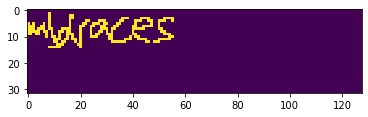

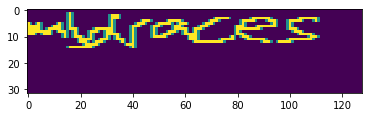

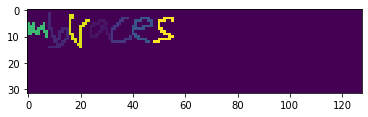

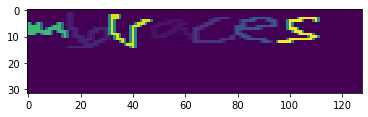

In [25]:
from matplotlib import pyplot as plt
plt.imshow(x_train[5], interpolation='nearest')
plt.show()
plt.imshow(aug_x_train[5], interpolation='nearest')
plt.show()

plt.imshow(y_train[5], interpolation='nearest')
plt.show()

plt.imshow(aug_y_train[5], interpolation='nearest')
plt.show()


In [26]:
aug_x_val=[]
aug_y_val=[]
for im, gt in zip(x_val,y_val):
    aug_im,aug_gt=augment(im,gt)
    aug_x_val.append(aug_im)
    aug_y_val.append(aug_gt)

In [27]:
aug_x_train=array([array(aug_x) for aug_x in aug_x_train])
aug_x_val=array([array(aug_x) for aug_x in aug_x_val])


In [28]:
aug_y_train=array([array(aug_y) for aug_y in aug_y_train])
aug_y_val=array([array(aug_y) for aug_y in aug_y_val])

In [29]:
len(aug_y_train)


3481

In [30]:
x_train=np.concatenate((aug_x_train,x_train))
x_val=np.concatenate((aug_x_val,x_val))
y_train=np.concatenate((aug_y_train,y_train))
y_val=np.concatenate((aug_y_val,y_val))


In [31]:
len(x_val)

1754

In [35]:
len(x_train)

6962

In [33]:
x_train=array([np.dstack( ( im, np.zeros((32,128)), np.zeros((32,128))) ) for im in x_train])
# y_train=array([im.reshape((ibm.shape[0],im.shape[1],27)) for im in y_train])
x_val=array([np.dstack( ( im, np.zeros((32,128)), np.zeros((32,128))) ) for im in x_val])
# y_val=array([im.reshape((im.shape[0],im.shape[1],27)) for im in y_val])

In [34]:
x_train=x_train[0:100000]
y_train=y_train[0:100000]
x_val=x_val[0:25000]
y_val=y_val[0:25000]

In [ ]:
x_val=x_val[0:70000]
y_val=y_val[0:70000]

## getting the right data format to train the model

In [37]:
y_train = tf.cast(y_train, tf.int32)


In [38]:
y_train=array (tf.one_hot(y_train, 27 ,dtype=tf.float16 ))


In [39]:
y_val = tf.cast(y_val, tf.int32)

In [40]:
y_val=array (tf.one_hot(y_val, 27,dtype=tf.float16)  )


In [41]:
y_train.shape

(6962, 32, 128, 27)

In [42]:
x_val.shape

(1754, 32, 128, 3)

In [43]:
np.array(y_val).shape

(1754, 32, 128, 27)

## Training on the real data set with augmentation 

In [45]:


# load your data

# preprocess input


# define model
model = Unet(BACKBONE, encoder_weights='imagenet',activation="softmax",classes=27)
model.compile(optimizer=opt, loss=categorical_crossentropy, metrics=[precision,iou_score])

# fit model
model.fit(
    x=x_train,
    y=y_train,
    batch_size=32,
    epochs=100,
    validation_data=(x_val, y_val),
)

Train on 6962 samples, validate on 1754 samples
Epoch 1/100
6962/6962 [==============================] - 26s 4ms/step - loss: 0.0348 - precision: 0.0469 - iou_score: 0.0322 - val_loss: 0.0207 - val_precision: 0.0374 - val_iou_score: 0.0334
Epoch 2/100
6962/6962 [==============================] - 19s 3ms/step - loss: 0.0116 - precision: 0.0627 - iou_score: 0.0485 - val_loss: 0.0242 - val_precision: 0.0377 - val_iou_score: 0.0340
Epoch 3/100
6962/6962 [==============================] - 18s 3ms/step - loss: 0.0103 - precision: 0.0758 - iou_score: 0.0556 - val_loss: 0.0215 - val_precision: 0.0476 - val_iou_score: 0.0347
Epoch 4/100
6962/6962 [==============================] - 19s 3ms/step - loss: 0.0091 - precision: 0.0975 - iou_score: 0.0680 - val_loss: 0.0137 - val_precision: 0.0761 - val_iou_score: 0.0410
Epoch 5/100
6962/6962 [==============================] - 18s 3ms/step - loss: 0.0081 - precision: 0.1230 - iou_score: 0.0837 - val_loss: 0.0084 - val_precision: 0.1138 - val_iou_score:

In [46]:
history=model.history.history

In [47]:
history['precision'][49]

0.9681589

In [48]:
history['val_precision'][49]

0.5337522029876709

In [49]:
history['iou_score'][49]

0.9500575

In [50]:
history['val_iou_score'][49]

0.5187381505966187

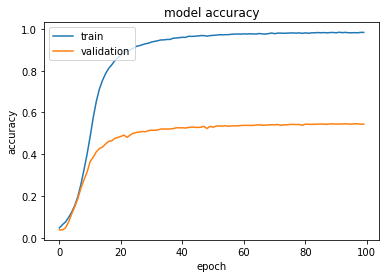

In [51]:
# summarize history for accuracy
plt.plot(history['precision'])
plt.plot(history['val_precision'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

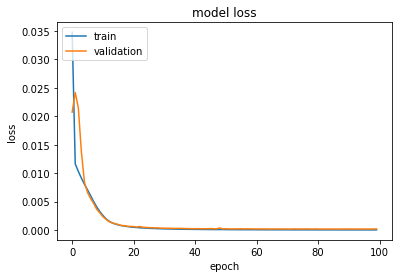

In [52]:
# summarize history for loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

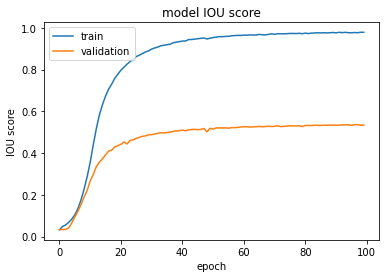

In [53]:
# summarize history for IoU
plt.plot(history['iou_score'])
plt.plot(history['val_iou_score'])
plt.title('model IOU score')
plt.ylabel('IOU score')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Training on the synthetic dataset with augmentation 

# Model 1 trained on 50 000 images¶


In [ ]:


# load your data

# preprocess input


# define model
model = Unet(BACKBONE, encoder_weights='imagenet',activation="softmax",classes=27)
model.compile(optimizer=opt, loss=categorical_crossentropy, metrics=[precision,iou_score])

# fit model
model.fit(
    x=x_train,
    y=y_train,
    batch_size=32,
    epochs=100,
    validation_data=(x_val, y_val),
)

In [165]:
history1=model1.history.history

In [166]:
history1.keys()

dict_keys(['loss', 'precision', 'iou_score', 'val_loss', 'val_precision', 'val_iou_score'])

In [167]:
history1['precision'][49]

0.94563645

In [168]:
history1['val_precision'][49]

0.50142586

In [169]:
history1['iou_score'][49]

0.9403951

In [170]:
history1['val_iou_score'][49]

0.46593165

In [171]:
from matplotlib import pyplot as plt

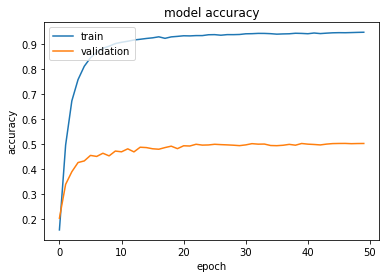

In [172]:
# summarize history for accuracy
plt.plot(history1['precision'])
plt.plot(history1['val_precision'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

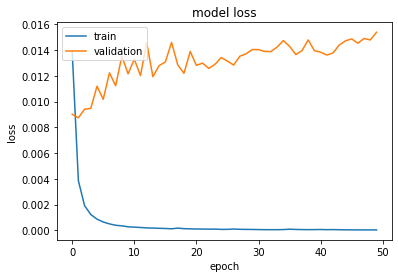

In [173]:
# summarize history for loss
plt.plot(history1['loss'])
plt.plot(history1['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

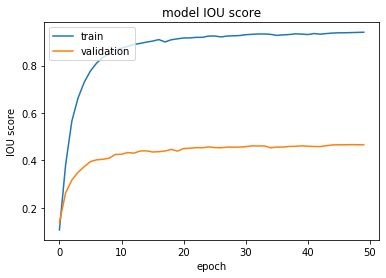

In [174]:
# summarize history for Iou
plt.plot(history1['iou_score'])
plt.plot(history1['val_iou_score'])
plt.title('model IOU score')
plt.ylabel('IOU score')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Model 2 trained on 60 000 images¶


In [185]:
# define model
model2 = Unet(BACKBONE, encoder_weights='imagenet',activation="softmax",classes=27)
model2.compile(optimizer=opt, loss=categorical_crossentropy, metrics=[precision,iou_score])

# fit model
model2.fit(
    x=x_train[0:60000],
    y=y_train[0:60000],
    batch_size=32,
    epochs=50,
    validation_data=(x_val, y_val),
)

Train on 60000 samples, validate on 25000 samples
Epoch 1/50
60000/60000 [==============================] - 82s 1ms/sample - loss: 0.0098 - precision: 0.1962 - iou_score: 0.1353 - val_loss: 0.0059 - val_precision: 0.2525 - val_iou_score: 0.1710
Epoch 2/50
60000/60000 [==============================] - 77s 1ms/sample - loss: 0.0034 - precision: 0.5245 - iou_score: 0.4053 - val_loss: 0.0036 - val_precision: 0.4216 - val_iou_score: 0.3244
Epoch 3/50
60000/60000 [==============================] - 77s 1ms/sample - loss: 0.0018 - precision: 0.6966 - iou_score: 0.5815 - val_loss: 0.0027 - val_precision: 0.5121 - val_iou_score: 0.4153
Epoch 4/50
60000/60000 [==============================] - 76s 1ms/sample - loss: 0.0012 - precision: 0.7700 - iou_score: 0.6703 - val_loss: 0.0022 - val_precision: 0.5609 - val_iou_score: 0.4696
Epoch 5/50
60000/60000 [==============================] - 77s 1ms/sample - loss: 9.1347e-04 - precision: 0.8143 - iou_score: 0.7304 - val_loss: 0.0025 - val_precision: 0.

In [190]:
history2=model2.history.history

In [191]:
history2.keys()

dict_keys(['loss', 'precision', 'iou_score', 'val_loss', 'val_precision', 'val_iou_score'])

In [192]:
history2['precision'][49]

0.9485409

In [193]:
history2['val_precision'][49]

0.74730504

In [194]:
history2['iou_score'][49]

0.9403441

In [195]:
history2['val_iou_score'][49]

0.68803114

In [196]:
from matplotlib import pyplot as plt

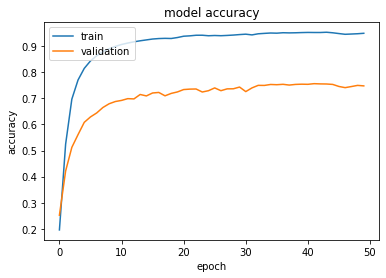

In [197]:
# summarize history for accuracy
plt.plot(history2['precision'])
plt.plot(history2['val_precision'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

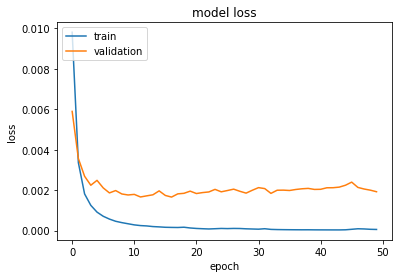

In [198]:
# summarize history for loss
plt.plot(history2['loss'])
plt.plot(history2['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

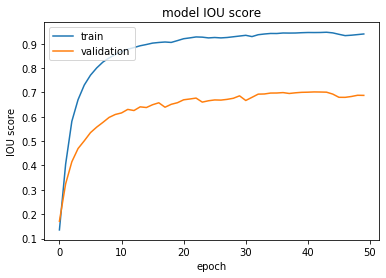

In [199]:
# summarize history for IoU
plt.plot(history2['iou_score'])
plt.plot(history2['val_iou_score'])
plt.title('model IOU score')
plt.ylabel('IOU score')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Model 3 trained on 70 000 images¶


In [200]:
# define model
model3 = Unet(BACKBONE, encoder_weights='imagenet',activation="softmax",classes=27)
model3.compile(optimizer=opt, loss=categorical_crossentropy, metrics=[precision,iou_score])

# fit model
model3.fit(
    x=x_train[0:70000],
    y=y_train[0:70000],
    batch_size=32,
    epochs=50,
    validation_data=(x_val, y_val),
)

Train on 70000 samples, validate on 25000 samples
Epoch 1/50
70000/70000 [==============================] - 95s 1ms/sample - loss: 0.0086 - precision: 0.2209 - iou_score: 0.1532 - val_loss: 0.0043 - val_precision: 0.3357 - val_iou_score: 0.2400
Epoch 2/50
70000/70000 [==============================] - 91s 1ms/sample - loss: 0.0028 - precision: 0.5723 - iou_score: 0.4481 - val_loss: 0.0024 - val_precision: 0.5077 - val_iou_score: 0.4011
Epoch 3/50
70000/70000 [==============================] - 91s 1ms/sample - loss: 0.0016 - precision: 0.7071 - iou_score: 0.5958 - val_loss: 0.0018 - val_precision: 0.5796 - val_iou_score: 0.4819
Epoch 4/50
70000/70000 [==============================] - 91s 1ms/sample - loss: 0.0011 - precision: 0.7759 - iou_score: 0.6795 - val_loss: 0.0014 - val_precision: 0.6356 - val_iou_score: 0.5440
Epoch 5/50
70000/70000 [==============================] - 91s 1ms/sample - loss: 8.0955e-04 - precision: 0.8162 - iou_score: 0.7337 - val_loss: 0.0013 - val_precision: 0.

In [201]:
history3=model3.history.history

In [202]:
history3['precision'][49]

0.9516943

In [203]:
history3['val_precision'][49]

0.7879129

In [204]:
history3['iou_score'][49]

0.9446744

In [205]:
history3['val_iou_score'][49]

0.7452157

In [206]:
from matplotlib import pyplot as plt

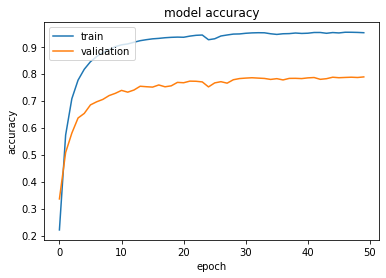

In [207]:
# summarize history for accuracy
plt.plot(history3['precision'])
plt.plot(history3['val_precision'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

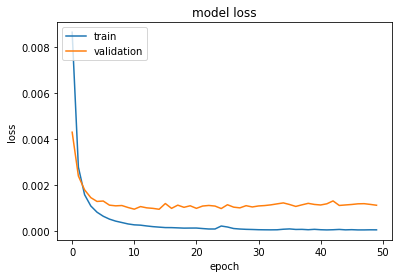

In [208]:
# summarize history for loss
plt.plot(history3['loss'])
plt.plot(history3['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

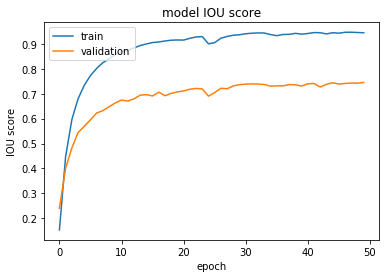

In [209]:
# summarize history for loss
plt.plot(history3['iou_score'])
plt.plot(history3['val_iou_score'])
plt.title('model IOU score')
plt.ylabel('IOU score')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Model 4 trained on 80 000 images¶


In [210]:
# define model
model4 = Unet(BACKBONE, encoder_weights='imagenet',activation="softmax",classes=27)
model4.compile(optimizer=opt, loss=categorical_crossentropy, metrics=[precision,iou_score])

# fit model
model4.fit(
    x=x_train[0:80000],
    y=y_train[0:80000],
    batch_size=32,
    epochs=50,
    validation_data=(x_val, y_val),
)

Train on 80000 samples, validate on 25000 samples
Epoch 1/50
80000/80000 [==============================] - 104s 1ms/sample - loss: 0.0081 - precision: 0.2240 - iou_score: 0.1550 - val_loss: 0.0038 - val_precision: 0.3556 - val_iou_score: 0.2555
Epoch 2/50
80000/80000 [==============================] - 100s 1ms/sample - loss: 0.0027 - precision: 0.5525 - iou_score: 0.4276 - val_loss: 0.0022 - val_precision: 0.5261 - val_iou_score: 0.4134
Epoch 3/50
80000/80000 [==============================] - 100s 1ms/sample - loss: 0.0016 - precision: 0.6898 - iou_score: 0.5745 - val_loss: 0.0016 - val_precision: 0.6056 - val_iou_score: 0.4964
Epoch 4/50
80000/80000 [==============================] - 100s 1ms/sample - loss: 0.0011 - precision: 0.7580 - iou_score: 0.6574 - val_loss: 0.0014 - val_precision: 0.6470 - val_iou_score: 0.5488
Epoch 5/50
80000/80000 [==============================] - 100s 1ms/sample - loss: 8.4100e-04 - precision: 0.8005 - iou_score: 0.7129 - val_loss: 0.0011 - val_precisio

In [211]:
history4=model4.history.history

In [212]:
history4['precision'][49]

0.9489124

In [213]:
history4['val_precision'][49]

0.79522204

In [214]:
history4['iou_score'][49]

0.93995285

In [215]:
history4['val_iou_score'][49]

0.7552322

In [216]:
from matplotlib import pyplot as plt

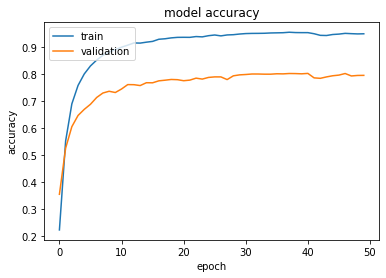

In [217]:
# summarize history for accuracy
plt.plot(history4['precision'])
plt.plot(history4['val_precision'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

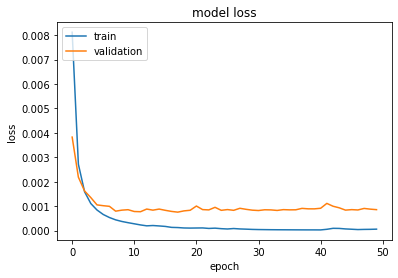

In [218]:
# summarize history for loss
plt.plot(history4['loss'])
plt.plot(history4['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

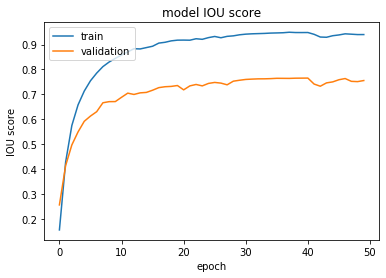

In [219]:
# summarize history for loss
plt.plot(history4['iou_score'])
plt.plot(history4['val_iou_score'])
plt.title('model IOU score')
plt.ylabel('IOU score')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Model 5 trained on 90 000 images¶


In [61]:
from segmentation_models import Unet
from segmentation_models import get_preprocessing
from segmentation_models.losses import categorical_crossentropy
from segmentation_models.metrics import iou_score, precision


BACKBONE = 'resnet34'
preprocess_input = get_preprocessing(BACKBONE)
opt=opt = tf.keras.optimizers.Adam(epsilon=1e-4)

# load your data

# preprocess input

# define model
model5 = Unet(BACKBONE, encoder_weights='imagenet',activation="softmax",classes=27)
model5.compile(optimizer=opt, loss=categorical_crossentropy, metrics=[precision,iou_score])

# fit model
model5.fit(
    x=x_train[0:90000],
    y=y_train[0:90000],
    batch_size=32,
    epochs=50,
    validation_data=(x_val, y_val),
)

Train on 90000 samples, validate on 25000 samples
Epoch 1/50
90000/90000 [==============================] - 132s 1ms/sample - loss: 0.0104 - precision: 0.1619 - iou_score: 0.1114 - val_loss: 0.0050 - val_precision: 0.3008 - val_iou_score: 0.2032
Epoch 2/50
90000/90000 [==============================] - 112s 1ms/sample - loss: 0.0032 - precision: 0.4945 - iou_score: 0.3748 - val_loss: 0.0023 - val_precision: 0.5151 - val_iou_score: 0.4121
Epoch 3/50
90000/90000 [==============================] - 113s 1ms/sample - loss: 0.0017 - precision: 0.6708 - iou_score: 0.5534 - val_loss: 0.0041 - val_precision: 0.5525 - val_iou_score: 0.4507
Epoch 4/50
90000/90000 [==============================] - 112s 1ms/sample - loss: 0.0012 - precision: 0.7454 - iou_score: 0.6395 - val_loss: 0.0031 - val_precision: 0.6039 - val_iou_score: 0.5073
Epoch 5/50
90000/90000 [==============================] - 112s 1ms/sample - loss: 0.0012 - precision: 0.7530 - iou_score: 0.6478 - val_loss: 0.0013 - val_precision: 0

In [62]:
history5=model5.history.history

In [63]:
history5['precision'][49]

0.9521983

In [64]:
history5['val_precision'][49]

0.79079646

In [65]:
history5['iou_score'][49]

0.94632083

In [66]:
history5['val_iou_score'][49]

0.7588022

In [67]:
from matplotlib import pyplot as plt

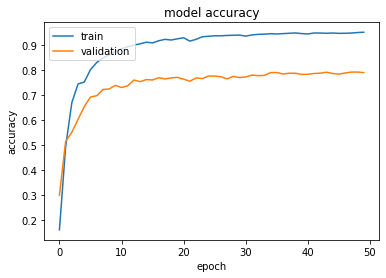

In [68]:
# summarize history for accuracy
plt.plot(history5['precision'])
plt.plot(history5['val_precision'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

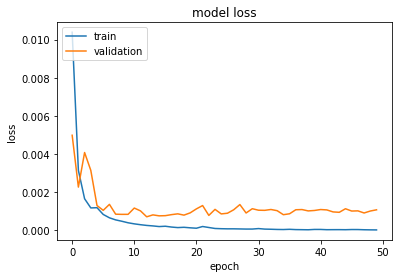

In [69]:
# summarize history for loss
plt.plot(history5['loss'])
plt.plot(history5['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

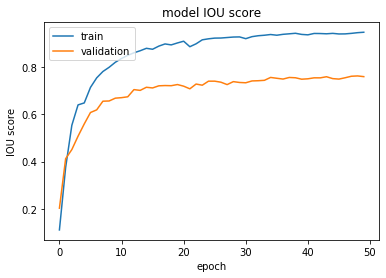

In [70]:
# summarize history for loss
plt.plot(history5['iou_score'])
plt.plot(history5['val_iou_score'])
plt.title('model IOU score')
plt.ylabel('IOU score')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Model 6 trained on 100 000 images

In [175]:
# define model
model6 = Unet(BACKBONE, encoder_weights='imagenet',activation="softmax",classes=27)
model6.compile(optimizer=opt, loss=categorical_crossentropy, metrics=[precision,iou_score])

# fit model
model6.fit(
    x=x_train[0:100000],
    y=y_train[0:100000],
    batch_size=32,
    epochs=50,
    validation_data=(x_val, y_val),
)

Train on 100000 samples, validate on 25000 samples
Epoch 1/50
100000/100000 [==============================] - 127s 1ms/sample - loss: 0.0070 - precision: 0.2506 - iou_score: 0.1755 - val_loss: 0.0033 - val_precision: 0.4021 - val_iou_score: 0.2959
Epoch 2/50
100000/100000 [==============================] - 123s 1ms/sample - loss: 0.0023 - precision: 0.5696 - iou_score: 0.4491 - val_loss: 0.0018 - val_precision: 0.5658 - val_iou_score: 0.4516
Epoch 3/50
100000/100000 [==============================] - 123s 1ms/sample - loss: 0.0014 - precision: 0.6981 - iou_score: 0.5880 - val_loss: 0.0013 - val_precision: 0.6384 - val_iou_score: 0.5393
Epoch 4/50
100000/100000 [==============================] - 123s 1ms/sample - loss: 9.4671e-04 - precision: 0.7693 - iou_score: 0.6727 - val_loss: 9.5554e-04 - val_precision: 0.6847 - val_iou_score: 0.5998
Epoch 5/50
100000/100000 [==============================] - 123s 1ms/sample - loss: 7.1209e-04 - precision: 0.8121 - iou_score: 0.7287 - val_loss: 8.

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



100000/100000 [==============================] - 123s 1ms/sample - loss: 2.9463e-05 - precision: 0.9502 - iou_score: 0.9440 - val_loss: 4.6204e-04 - val_precision: 0.8161 - val_iou_score: 0.7871
Epoch 35/50
100000/100000 [==============================] - 123s 1ms/sample - loss: 2.6998e-05 - precision: 0.9510 - iou_score: 0.9452 - val_loss: 4.8788e-04 - val_precision: 0.8155 - val_iou_score: 0.7852
Epoch 36/50
100000/100000 [==============================] - 123s 1ms/sample - loss: 2.7804e-05 - precision: 0.9508 - iou_score: 0.9449 - val_loss: 5.1771e-04 - val_precision: 0.8142 - val_iou_score: 0.7811
Epoch 37/50
100000/100000 [==============================] - 123s 1ms/sample - loss: 3.0316e-05 - precision: 0.9507 - iou_score: 0.9445 - val_loss: 4.9591e-04 - val_precision: 0.8144 - val_iou_score: 0.7841
Epoch 38/50
100000/100000 [==============================] - 123s 1ms/sample - loss: 3.2484e-05 - precision: 0.9499 - iou_score: 0.9435 - val_loss: 4.9999e-04 - val_precision: 0.8155 -

In [176]:
history6=model6.history.history

In [177]:
history6['precision'][49]

0.9502203

In [178]:
history6['val_precision'][49]

0.8112839

In [179]:
history6['iou_score'][49]

0.9435303

In [180]:
history6['val_iou_score'][49]

0.7813241

In [1]:
from matplotlib import pyplot as plt

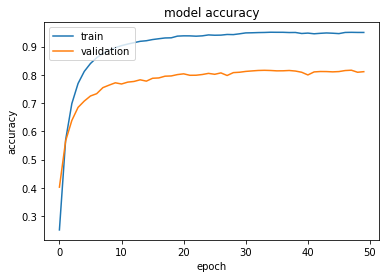

In [182]:
# summarize history for accuracy
plt.plot(history6['precision'])
plt.plot(history6['val_precision'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

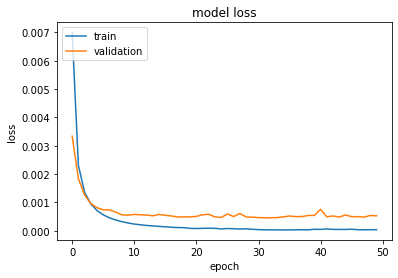

In [183]:
# summarize history for loss
plt.plot(history6['loss'])
plt.plot(history6['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

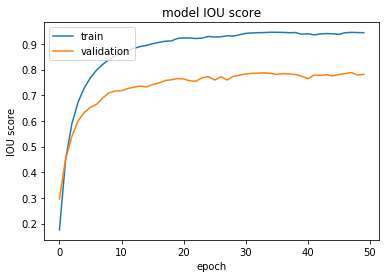

In [184]:
# summarize history for loss
plt.plot(history6['iou_score'])
plt.plot(history6['val_iou_score'])
plt.title('model IOU score')
plt.ylabel('IOU score')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [5]:
train_precision=[0.94563645,0.9485409,0.9516943,0.9489124,0.9521983,0.9502203]

In [6]:
val_precision=[0.50142586,0.74730504,0.7879129,0.79522204,0.79079646,0.8112839]

In [7]:
data_size=[50000,60000,70000,80000,90000,100000]

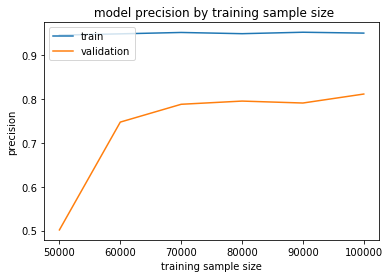

In [8]:
plt.plot(data_size,train_precision)
plt.plot(data_size,val_precision)
plt.title(' model precision by training sample size')
plt.ylabel('precision')
plt.xlabel('training sample size')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()